# Part B: K-Means Clustering - Anuran Calls Dataset (MFCCs)

## Step 1: Data Preprocessing and Exploration

### Importing Libraries

First, we import the necessary libraries for our analysis.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### Loading the Dataset

In [4]:
data = pd.read_csv("Frogs_MFCCs.csv")
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [6]:
print("Missing values in the dataset:")
missing_values = data.isnull().sum()
print(missing_values)

Missing values in the dataset:
MFCCs_ 1    0
MFCCs_ 2    0
MFCCs_ 3    0
MFCCs_ 4    0
MFCCs_ 5    0
MFCCs_ 6    0
MFCCs_ 7    0
MFCCs_ 8    0
MFCCs_ 9    0
MFCCs_10    0
MFCCs_11    0
MFCCs_12    0
MFCCs_13    0
MFCCs_14    0
MFCCs_15    0
MFCCs_16    0
MFCCs_17    0
MFCCs_18    0
MFCCs_19    0
MFCCs_20    0
MFCCs_21    0
MFCCs_22    0
Family      0
Genus       0
Species     0
RecordID    0
dtype: int64


### Data Scaling
We separate the features from the target values and standardize the features to have a mean of zero and a standard deviation of one.
We make use of StandardScalar for this.

In [9]:
X = data.iloc[:, :-4] # last 4 cols are considered the labels
y = data.iloc[:, -4:]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

### Feature Engineering
We create polynomial features to capture more complex relationships between the MFCCs.

In [11]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))
print("Shape of the new feature matrix with polynomial features:", X_poly_df.shape)

Shape of the new feature matrix with polynomial features: (7195, 275)


### Feature Correlation Analysis
We calculate the correlation matrix, identify highly correlated features, and remove them to avoid redundancy.

In [14]:
corr_matrix = X_poly_df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

highly_correlated = [column for column in upper.columns if any(upper[column] > 0.95)]

# dropping highly correlated features
X_final = X_poly_df.drop(highly_correlated, axis=1)
print("Shape of the final feature matrix after removing highly correlated features:", X_final.shape)


Shape of the final feature matrix after removing highly correlated features: (7195, 275)


## Step 2: K-Means Clustering


### Initialising Centroids Randomly
We initialise centroids randomly for now, we will use K-Means++ later on.

In [18]:
def initialize_centroids_random(X, k):
    np.random.seed(42)
    random_indices = np.random.permutation(X.shape[0])
    centroids = X[random_indices[:k]]
    return centroids

### Assigning Clusters

Assign each data point to the nearest centroid based on Euclidean distance.

In [21]:
def assign_clusters(X, centroids):
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    cluster_assignments = np.argmin(distances, axis=0)
    return cluster_assignments

### Updating Centroids

Update the centroids to be the mean of all points assigned to each centroid.

In [24]:
def update_centroids(X, cluster_assignments, k):
    new_centroids = np.array([X[cluster_assignments == i].mean(axis=0) for i in range(k)])
    return new_centroids

### K-Means Algorithm

Implement the K-Means clustering algorithm by iterating between assigning clusters and updating centroids.

In [27]:
def kmeans(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids_random(X, k)
    # print("Considering k =", k)
    for i in range(max_iters):
        old_centroids = centroids
        cluster_assignments = assign_clusters(X, centroids)
        centroids = update_centroids(X, cluster_assignments, k)
        if np.all(np.abs(centroids - old_centroids) < tol):
            break
        # for j, centroid in enumerate(centroids):
        #     print(f"Centroid {j} for iteration {i}: {centroid[:5]}... (first 5 features)")
    return cluster_assignments, centroids

### Elbow Method

The Elbow Method helps us determine the optimal number of clusters by plotting the sum of squared distances from each point to its assigned cluster center. The "elbow" point on the plot indicates the optimal number of clusters.

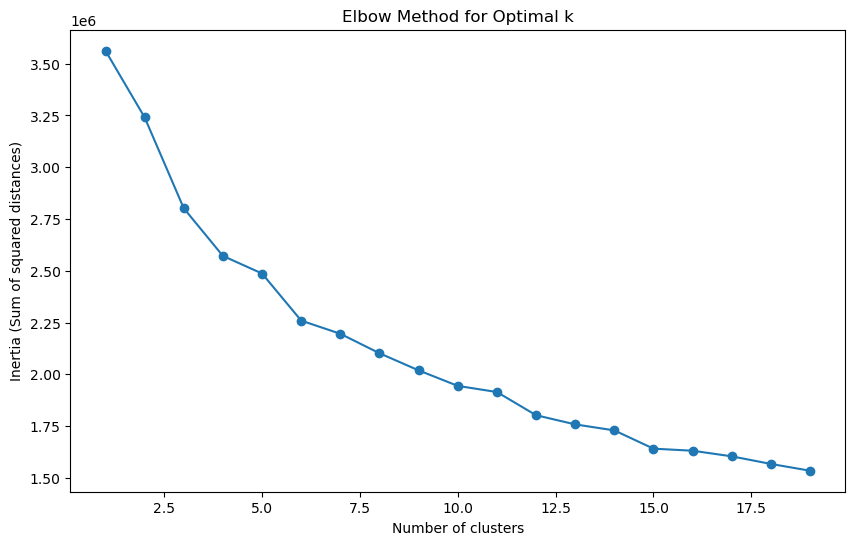

In [43]:
def calculate_inertia(X, centroids, cluster_assignments):
    inertia = 0
    for i in range(centroids.shape[0]):
        cluster_points = X[cluster_assignments == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

k_values = range(1, 20)
inertias = []

for k in k_values:
    cluster_assignments, centroids = kmeans(X_final.values, k)
    inertia = calculate_inertia(X_final.values, centroids, cluster_assignments)
    inertias.append(inertia)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()

### Executing the proper K Means with optimal K and Evaluating it
We select **K = 4**, since from the above plot it seems to be the elbow point (though it isn't as pronounced)

### Silhouette Score Evaluation

The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. Higher scores indicate better-defined clusters.

In [54]:
def calculate_silhouette_score(X, cluster_assignments, centroids):
    silhouette_scores = []
    for i in range(X.shape[0]):
        current_cluster = cluster_assignments[i]
        other_clusters = np.delete(np.arange(centroids.shape[0]), current_cluster)

        a = np.mean(np.linalg.norm(X[cluster_assignments == current_cluster] - X[i], axis=1))
        b = np.min([np.mean(np.linalg.norm(X[cluster_assignments == c] - X[i], axis=1)) for c in other_clusters])
        silhouette_scores.append((b - a) / max(a, b))

    return np.mean(silhouette_scores)

optimal_k = 4
cluster_assignments, centroids = kmeans(X_final.values, optimal_k)
silhouette_avg = calculate_silhouette_score(X_final.values, cluster_assignments, centroids)
print(f'Silhouette Score for k={optimal_k}: {silhouette_avg}')

Silhouette Score for k=4: 0.41179442410177447


### Initialising Centroids with K-Means++
Implementing k-means++ initialization for selecting initial centroids.


In [57]:
def initialize_centroids_kmeanspp(X, k):
    np.random.seed(42)
    centroids = np.empty((k, X.shape[1]))
    
    centroids[0] = X[np.random.choice(X.shape[0])]
    
    for i in range(1, k):
        distances = np.min(np.sqrt(((X - centroids[:i, np.newaxis])**2).sum(axis=2)), axis=0)
        probabilities = distances / np.sum(distances)
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probabilities):
            if r < p:
                centroids[i] = X[j]
                break
    
    return centroids

### Updated K-Means Function with K-Means++ Initialisation
Updating the K-Means clustering function to use the k-means++ initialization 

In [60]:
def kmeanspp(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids_kmeanspp(X, k)
    # print("Considering k =", k)
    for i in range(max_iters):
        old_centroids = centroids
        cluster_assignments = assign_clusters(X, centroids)
        centroids = update_centroids(X, cluster_assignments, k)
        if np.all(np.abs(centroids - old_centroids) < tol):
            break
        # for j, centroid in enumerate(centroids):
        #     print(f"Centroid {j} for iteration {i}: {centroid[:5]}... (first 5 features)")
    return cluster_assignments, centroids

We plot the elbow method output once again to find optimal K.

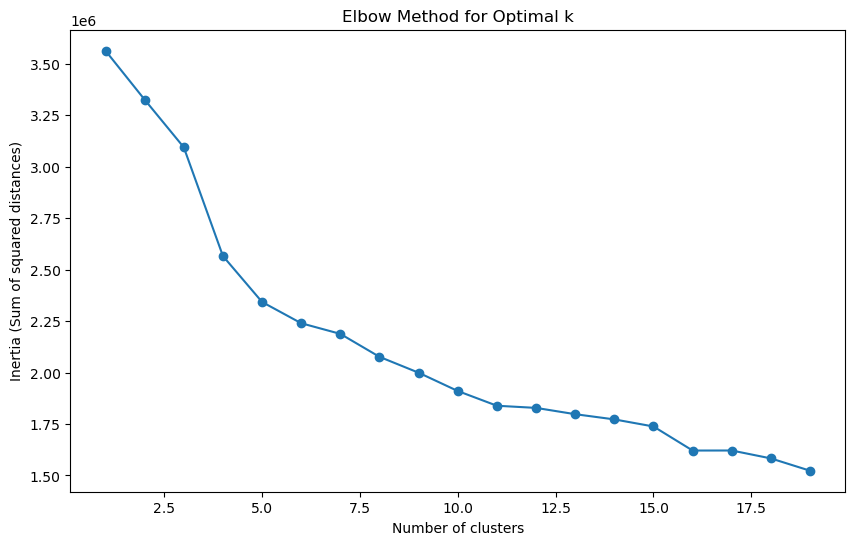

In [63]:
def calculate_inertia(X, centroids, cluster_assignments):
    inertia = 0
    for i in range(centroids.shape[0]):
        cluster_points = X[cluster_assignments == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

k_values = range(1, 20)
inertias = []

for k in k_values:
    cluster_assignmentspp, centroidspp = kmeanspp(X_final.values, k)
    inertia = calculate_inertia(X_final.values, centroidspp, cluster_assignmentspp)
    inertias.append(inertia)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()

### Silhoutte Score Evaluation
We select **K=5** since that is the elbow point in this case.

In [66]:
optimal_k = 5
cluster_assignmentspp, centroidspp = kmeanspp(X_final.values, optimal_k)
silhouette_avg = calculate_silhouette_score(X_final.values, cluster_assignmentspp, centroidspp)
print(f'Silhouette Score for k={optimal_k}: {silhouette_avg}')

Silhouette Score for k=5: 0.427095460133813


### Adding the Cluster Labelling to the Dataframe
We see that the Silhouette Score for K-Means++ is higher than random initialisation (even if its by a small margin). So we assign the clusters returned by K-Means++ to the original dataframe datapoints.

In [69]:
data['Cluster'] = cluster_assignmentspp

In [71]:
value_counts = data['Cluster'].value_counts()
print(value_counts)

Cluster
4    5692
0     588
1     454
2     393
3      68
Name: count, dtype: int64


# Step 3: Cluster Visualisation
Since the number of features is 275 (after feature engineering), which cannot be plotted on a scatterplot, we apply **PCA** and **t-SNE** to reduce the dimensionality to 2 components, and then plot them.

We'll follow these steps for a basic PCA implementation:
- Standardize the Data: Data already standardised by StandardScalar.
- Compute the Covariance Matrix: Find the covariance matrix of the data.
- Calculate Eigenvalues and Eigenvectors: Determine the eigenvalues and eigenvectors of the covariance matrix.
- Sort Eigenvectors: Sort eigenvectors by the magnitude of their corresponding eigenvalues.
- Project Data: Project the data onto the selected eigenvectors.

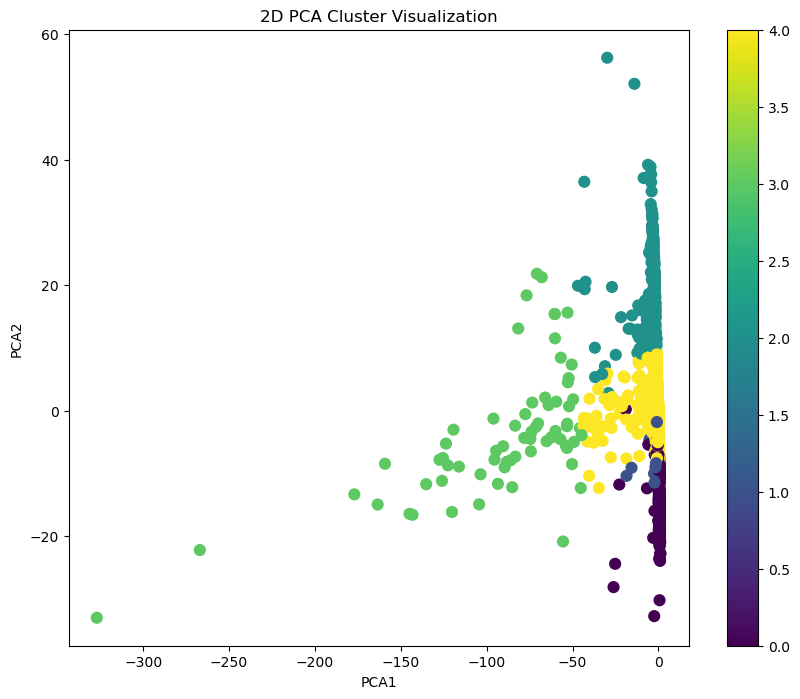

In [74]:
cov_matrix = np.cov(X_final.values, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

top_eigenvectors = sorted_eigenvectors[:, :2]

X_pca = np.dot(X_final, top_eigenvectors)

pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', s=60)
plt.title('2D PCA Cluster Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.show()

For **t-SNE**, I'm using the sklearn TSNE, since we haven't been taught how to implement it from scratch. However, t-SNE does a better job in capturing the clustering, hence the plot below has been made.

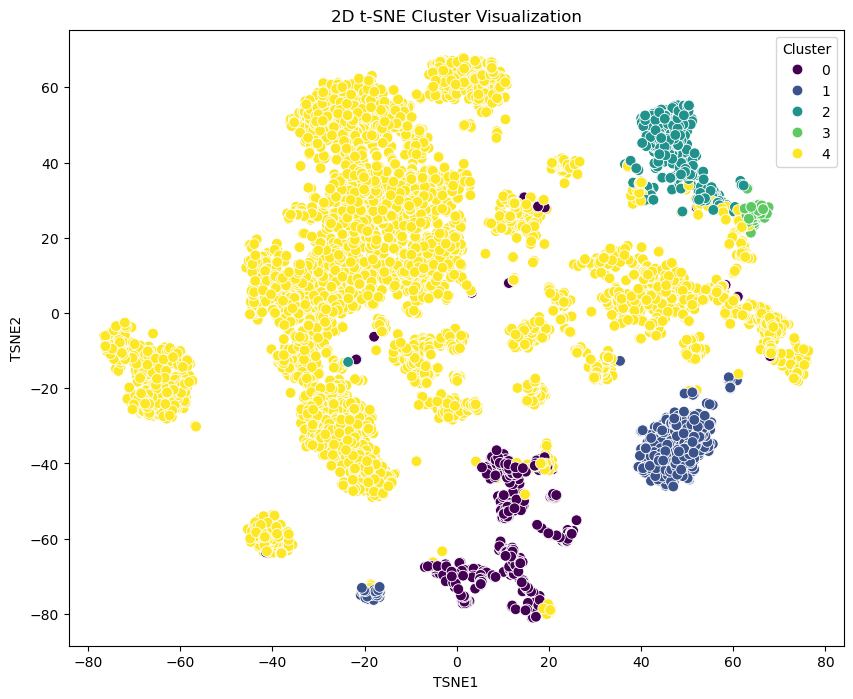

In [77]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_final.values)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = data['Cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', s=60)
plt.title('2D t-SNE Cluster Visualization')
plt.show()

### Feature Contribution
We'll look at the contributions of each feature to the first two principal components for our PCA analysis.

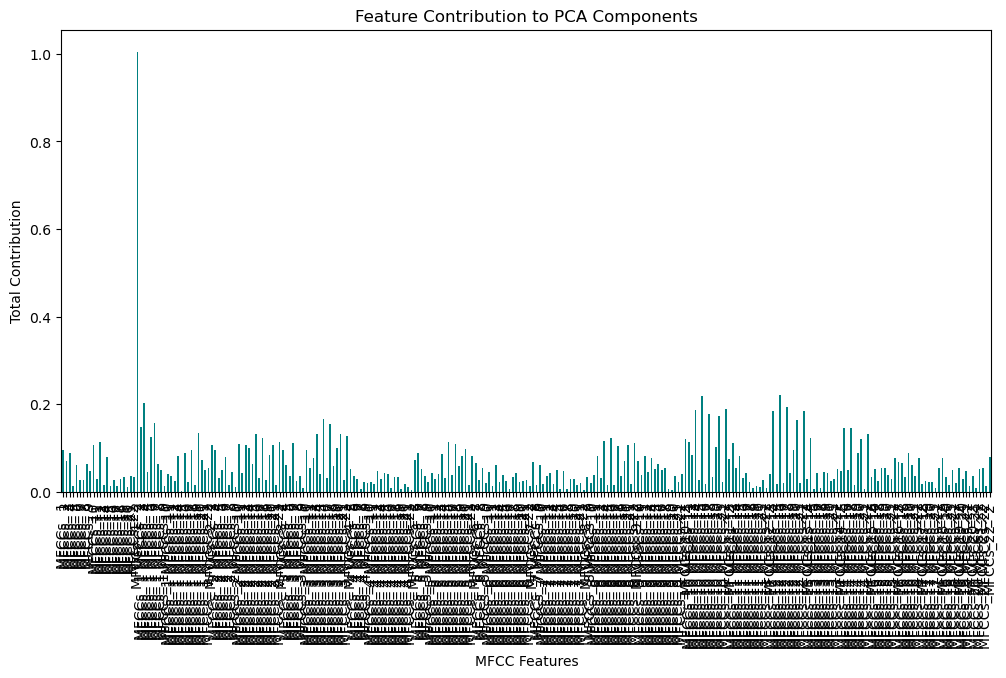

In [95]:
contributions = pd.DataFrame(sorted_eigenvectors[:, :2], columns=['PCA1', 'PCA2'], index=X_final.columns)
contributions['Total Contribution'] = contributions.abs().sum(axis=1)

# sorted_contributions = contributions.sort_values(by='Total Contribution', ascending=False)

plt.figure(figsize=(12, 6))
contributions['Total Contribution'].plot(kind='bar', color='teal')
plt.title('Feature Contribution to PCA Components')
plt.xlabel('MFCC Features')
plt.ylabel('Total Contribution')
plt.show()

The plot is a bit hapazhard since we have 275 features, but it shows that some feature contribute higher than others.

This fact is verified by the t-SNE too. If we consider t-SNE, we get the following plot:

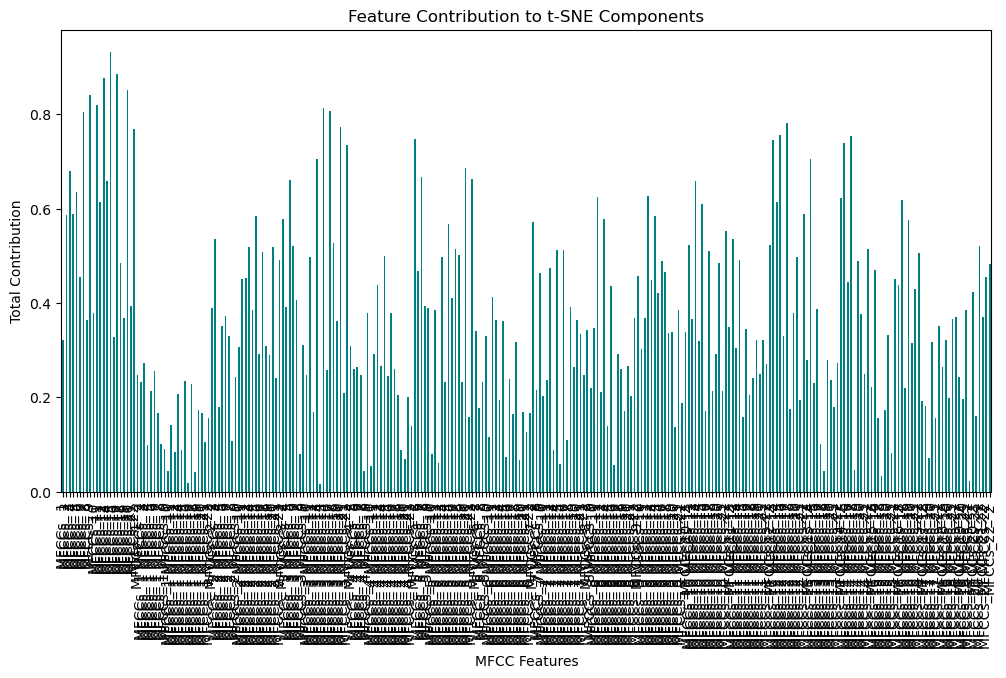

In [100]:
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
contributions = pd.DataFrame(X_final.values, columns=X_final.columns).corrwith(tsne_df['TSNE1']).abs() + pd.DataFrame(X_final.values, columns=X_final.columns).corrwith(tsne_df['TSNE2']).abs()
# contributions = contributions.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
contributions.plot(kind='bar', color='teal')
plt.title('Feature Contribution to t-SNE Components')
plt.xlabel('MFCC Features')
plt.ylabel('Total Contribution')
plt.show()


# Step 4: Cluster Evaluation Metrics
We calculate **Davies-Bouldin Index** and **Calinski-Harabasz Index** to assess the quality of clusters.
### Davies-Bouldin Index
The Davies-Bouldin Index evaluates the average similarity ratio of each cluster with respect to its most similar cluster. A lower value indicates better clustering.

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{S_i + S_j}{M_{ij}} \right)
$$
   
Where:
   - $$ k $$ is the number of clusters.
   - $$ S_i $$ is the intra-cluster distance for cluster \( i \).
   - $$ M_{ij} $$ is the inter-cluster distance between clusters \( i \) and \( j \).

### Calinski-Harabasz Index
The Calinski-Harabasz Index, also known as the Variance Ratio Criterion, evaluates the ratio of the sum of between-cluster dispersion and within-cluster dispersion. A higher value indicates better clustering.

$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \times \frac{(N - k)}{(k - 1)}
$$

Where:
- $$ \text{Tr}(B_k) $$ is the trace of the between-cluster dispersion matrix.
- $$ \text{Tr}(W_k) $$ is the trace of the within-cluster dispersion matrix.
- $$ N $$ is the total number of data points.
- $$ k $$ is the number of clusters.

**Note:** Since these indexes are quite complex to implement from scratch, I'll use the built-in functions from sklearn for calculating them.

For k=2, Davies-Bouldin Index: 1.8730642354522002, Calinski-Harabasz Index: 514.143509179128
For k=3, Davies-Bouldin Index: 1.6605751431990603, Calinski-Harabasz Index: 545.3019864564566
For k=4, Davies-Bouldin Index: 1.4981683284391902, Calinski-Harabasz Index: 931.5767456738738
For k=5, Davies-Bouldin Index: 1.4207948297923072, Calinski-Harabasz Index: 936.374266306559
For k=6, Davies-Bouldin Index: 1.5753306313350615, Calinski-Harabasz Index: 849.7346218261184
For k=7, Davies-Bouldin Index: 1.8811511782991617, Calinski-Harabasz Index: 753.0777955535939
For k=8, Davies-Bouldin Index: 1.7354190967633145, Calinski-Harabasz Index: 735.2043859852009
For k=9, Davies-Bouldin Index: 1.6636927961046473, Calinski-Harabasz Index: 702.6614062732762
For k=10, Davies-Bouldin Index: 1.6152583579938962, Calinski-Harabasz Index: 690.6767699410001
For k=11, Davies-Bouldin Index: 1.5846140406199316, Calinski-Harabasz Index: 673.6498721746611
For k=12, Davies-Bouldin Index: 1.693511283766288, Calinski-

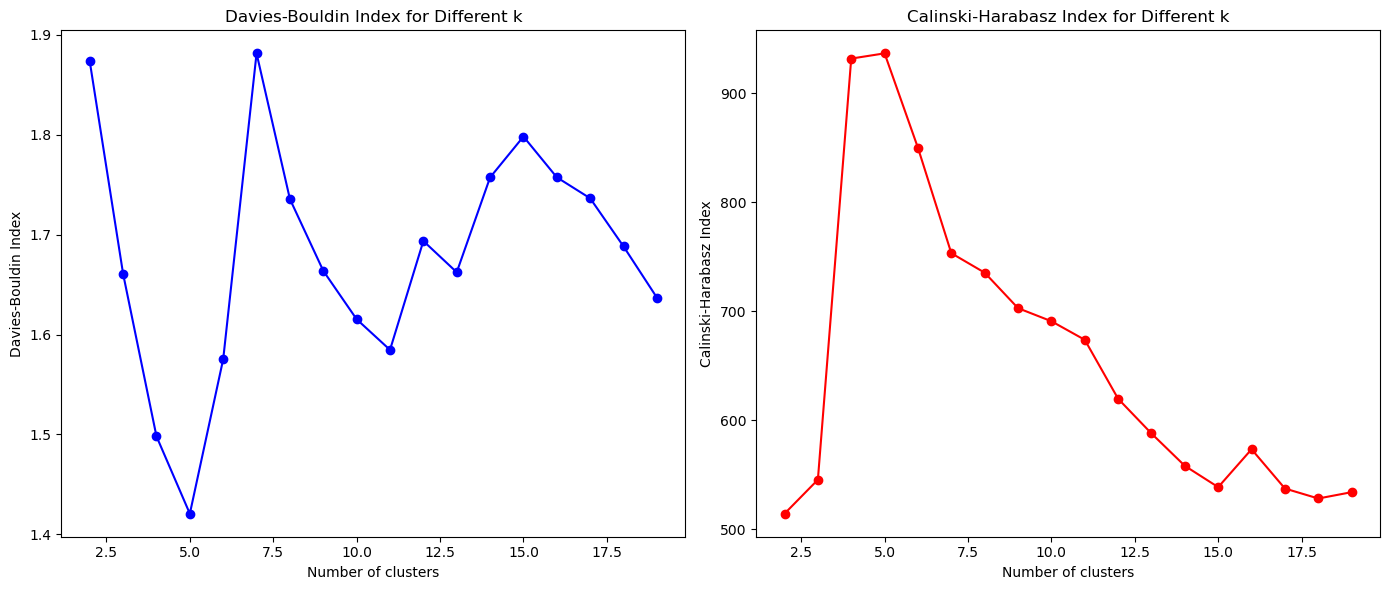

In [108]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

def evaluate_clusters(X, k_values):
    db_scores = []
    ch_scores = []
    for k in k_values:
        cluster_assignments, centroids = kmeanspp(X, k)
        db_score = davies_bouldin_score(X, cluster_assignments)
        ch_score = calinski_harabasz_score(X, cluster_assignments)
        db_scores.append(db_score)
        ch_scores.append(ch_score)
        print(f'For k={k}, Davies-Bouldin Index: {db_score}, Calinski-Harabasz Index: {ch_score}')
    return db_scores, ch_scores

k_values = range(2, 20) # to check that our Silhouette Score is correct.

db_scores, ch_scores = evaluate_clusters(X_final.values, k_values)

# plotting the indices to find the highest values easily
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, db_scores, marker='o', color='b')
plt.title('Davies-Bouldin Index for Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.subplot(1, 2, 2)
plt.plot(k_values, ch_scores, marker='o', color='r')
plt.title('Calinski-Harabasz Index for Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.tight_layout()
plt.show()


#### Clearly, for k = 5, we have the lowest DB Index and the highest CH Index, which verifies that the clustering quality is highest for K=5, and that our Silhouette Score and Elbow Method are valid.

# Step 5: Comparison with Other Clustering Algorithms
I'll be performing both **Agglomerative Hierarchical Clustering** and **DBSCAN** on the dataset. However, please note that I am using external libraries for them since the assignment was on K-Means.

### Agglomerative Hierarchical Clustering

#### Implementation

In [195]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=3) # set by a bit of hit and trial between 2, 3, 4, 5 and 6.
agg_clusters = agg_clustering.fit_predict(X_final.values)

data['Agglomerative Cluster'] = agg_clusters

#### Visualisation
1. Using **PCA**

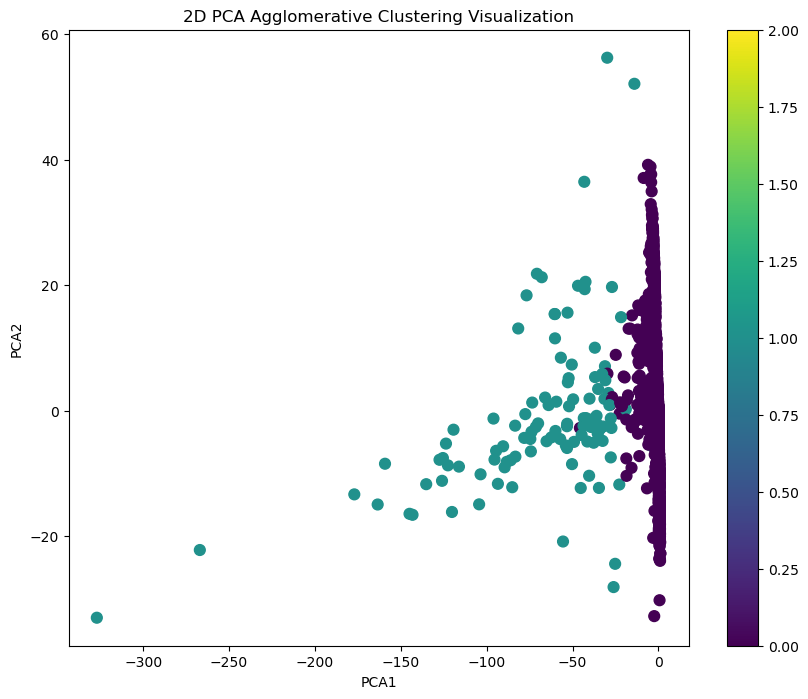

In [197]:
X_pca_agg = np.dot(X_final, top_eigenvectors)

pca_df_agg = pd.DataFrame(X_pca_agg, columns=['PCA1', 'PCA2'])
pca_df_agg['Cluster'] = data['Agglomerative Cluster']

plt.figure(figsize=(10, 8))
plt.scatter(pca_df_agg['PCA1'], pca_df_agg['PCA2'], c=pca_df_agg['Cluster'], cmap='viridis', s=60)
plt.title('2D PCA Agglomerative Clustering Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.show()

2. Using **t-SNE**

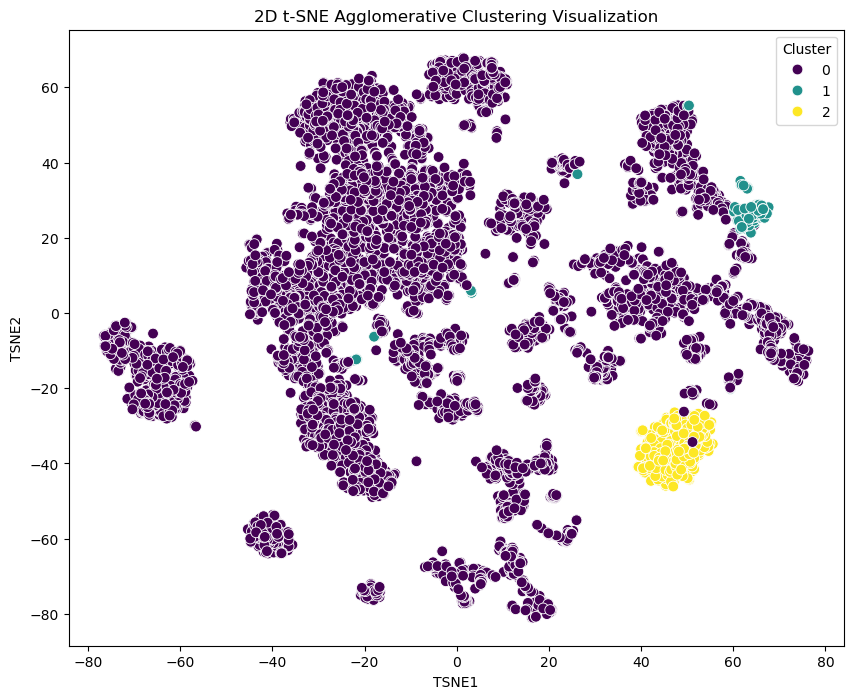

In [199]:
tsne_agg = TSNE(n_components=2, random_state=42)
X_tsne_agg = tsne_agg.fit_transform(X_final.values)

tsne_df_agg = pd.DataFrame(X_tsne_agg, columns=['TSNE1', 'TSNE2'])
tsne_df_agg['Cluster'] = data['Agglomerative Cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df_agg, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', s=60)
plt.title('2D t-SNE Agglomerative Clustering Visualization')
plt.show()

### Evaluation

In [201]:
db_score_agg = davies_bouldin_score(X_final.values, agg_clusters)
ch_score_agg = calinski_harabasz_score(X_final.values, agg_clusters)
print(f'Agglomerative Clustering - Davies-Bouldin Index: {db_score_agg}')
print(f'Agglomerative Clustering - Calinski-Harabasz Index: {ch_score_agg}')


Agglomerative Clustering - Davies-Bouldin Index: 1.1931521544499344
Agglomerative Clustering - Calinski-Harabasz Index: 911.68915206132


### DBSCAN

#### Implementation

In [289]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5) # both lower and higher values of eps made only 1 cluster
dbscan_clusters = dbscan.fit_predict(X_final.values)

data['DBSCAN Cluster'] = dbscan_clusters

### Visualisation
1. Using **PCA**

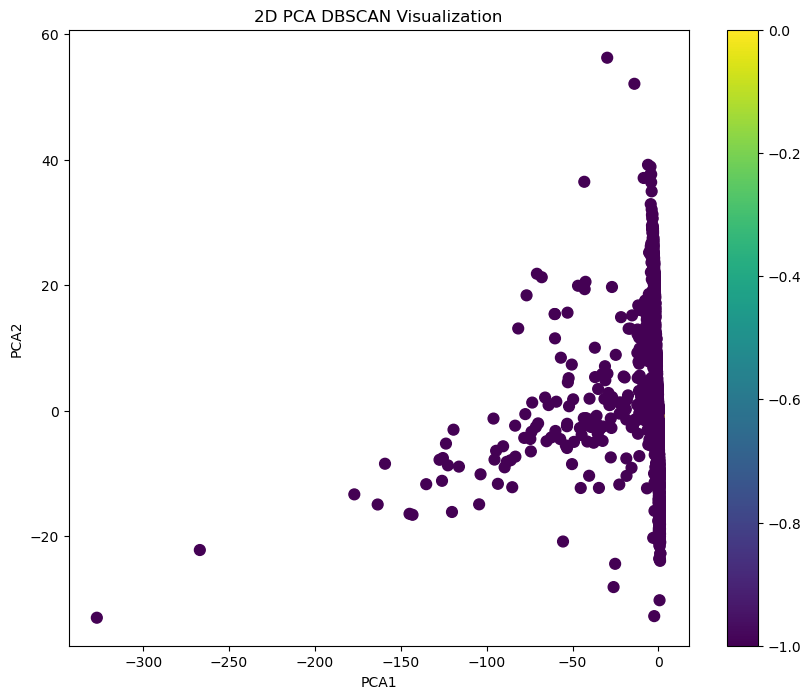

In [292]:
X_pca_dbscan = np.dot(X_final, top_eigenvectors)

pca_df_dbscan = pd.DataFrame(X_pca_dbscan, columns=['PCA1', 'PCA2'])
pca_df_dbscan['Cluster'] = data['DBSCAN Cluster']

plt.figure(figsize=(10, 8))
plt.scatter(pca_df_dbscan['PCA1'], pca_df_dbscan['PCA2'], c=pca_df_dbscan['Cluster'], cmap='viridis', s=60)
plt.title('2D PCA DBSCAN Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.show()


2. Using **t-SNE**

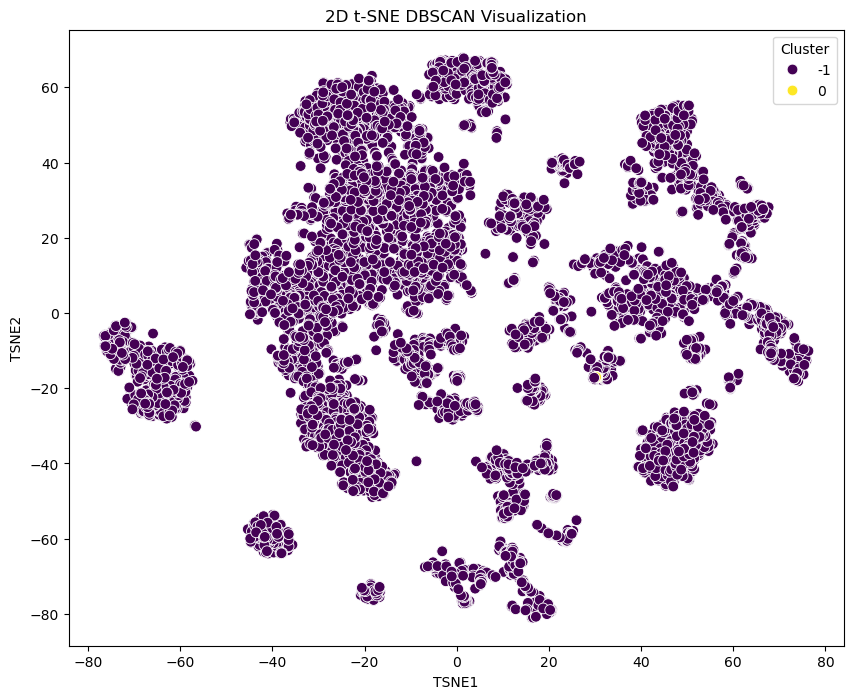

In [286]:
tsne_dbscan = TSNE(n_components=2, random_state=42)
X_tsne_dbscan = tsne_dbscan.fit_transform(X_final.values)

tsne_df_dbscan = pd.DataFrame(X_tsne_dbscan, columns=['TSNE1', 'TSNE2'])
tsne_df_dbscan['Cluster'] = data['DBSCAN Cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df_dbscan, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', s=60)
plt.title('2D t-SNE DBSCAN Visualization')
plt.show()


#### Evaluation

Since only 1 cluster was formed, we can say it performed poorer than both K-Means and Agglomerative Hierarchical Clustering.